In [1]:
import numpy as np
from matplotlib import pyplot as plt
from depth_map import createMap

## Make disparity map

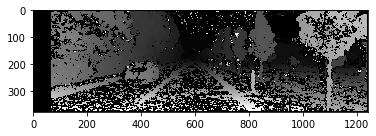

In [2]:
path_to_training = "KITTI/data_scene_flow/training/"
disparity = createMap(path_to_training,'000183_11.png')
plt.imshow(disparity, 'gray');

### Training set

In [5]:
N_IMAGES=200
uvd = np.array([[-16,-16,-16]]) # needed something to start, -16 will get chopped anyways
errs = 0
for img_idx in range(N_IMAGES):
    try:
        d = createMap(path_to_training,f'000{img_idx}_11.png')
        u = np.tile(range(d.shape[1]), d.shape[0])
        v = np.repeat(range(d.shape[0]), d.shape[1])
        uv_disp = np.array([u,v,d.flatten()]).T
        uvd = np.concatenate((uvd, uv_disp))
    except:
        errs +=1

In [6]:
errs

100

In [7]:
print(uvd.shape)
uvd

(46539647, 3)


array([[ -16,  -16,  -16],
       [   0,    0,  -16],
       [   1,    0,  -16],
       ...,
       [1238,  375,  -16],
       [1239,  375,  -16],
       [1240,  375,  -16]])

## Remove -16 (no data) pixels

In [8]:
uvd_noblanks = uvd[uvd[:,2]!=-16]
uvd_noblanks

array([[  74,    4,    0],
       [  76,    4,    0],
       [  77,    4,    0],
       ...,
       [1227,  371,  670],
       [1228,  371,  674],
       [1229,  371,  676]])

## Plot

### U (horizontal scan)

### V (vertical scan)

## Fit

In [9]:
from sklearn.linear_model import RANSACRegressor

In [10]:
u = uvd_noblanks[:,0].reshape(-1, 1)
v = uvd_noblanks[:,1].reshape(-1, 1)
d = uvd_noblanks[:,2]

### U

In [11]:
ransac_u = RANSACRegressor()
ransac_u.fit(u,d)
line_u = np.arange(u.min(), u.max())[:, np.newaxis]
line_du = ransac_u.predict(line_u)
#plt.scatter(x=u,y=d,s=0.00001)
#plt.plot(line_u, line_du, color='gold',linewidth=2,label="Ransac regressor");

### V

In [12]:
ransac_v = RANSACRegressor()
ransac_v.fit(v,d)
line_v = np.arange(v.min(), v.max())[:, np.newaxis]
line_dv = ransac_v.predict(line_v)
#plt.scatter(x=v,y=d,s=0.00001)
#plt.plot(line_v, line_dv, color='gold',linewidth=2,label="Ransac regressor");

In [13]:
# deal with the elbow
uvd_cut = uvd_noblanks[uvd_noblanks[:,1]>175]

In [14]:
v_cut = uvd_cut[:,1].reshape(-1, 1)
d_cut = uvd_cut[:,2]

In [15]:
ransac_v = RANSACRegressor()
ransac_v.fit(v_cut,d_cut)
line_v = np.arange(v.min(), v.max())[:, np.newaxis]
line_dv = ransac_v.predict(line_v)
#plt.scatter(x=v,y=d,s=0.00001)
#plt.plot(line_v, line_dv, color='gold',linewidth=2,label="Ransac regressor");

## Put it together

In [16]:
path_to_kitti = "KITTI/data_scene_flow/testing/"
disparity = createMap(path_to_kitti,'000183_11.png')

In [17]:
u = np.tile(range(disparity.shape[1]), disparity.shape[0])
v = np.repeat(range(disparity.shape[0]), disparity.shape[1])
uv_disp = np.array([u,v,disparity.flatten()]).T

In [18]:
uv_disp_noblanks = uv_disp[uv_disp[:,2]!=-16]

u = uv_disp_noblanks[:,0].reshape(-1, 1)
v = uv_disp_noblanks[:,1].reshape(-1, 1)
d = uv_disp_noblanks[:,2]

In [33]:
from PIL import Image
plt.imsave("temp.png", disparity)
img = Image.open("temp.png")

EPSILON = 10
for i,disp in enumerate(d):
    x = line_u[u[i]-line_u[0]-1]-line_u[0]-1
    y = line_v[v[i]-line_v[0]-1]-line_v[0]-1
    if disp <= line_dv[y]+EPSILON:
        img.putpixel((u[i][0],v[i][0]), (255,0,0))
    else:
        img.putpixel((u[i][0],v[i][0]), (0,255,0))
    
img.show();